In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.utils import np_utils
from keras import regularizers



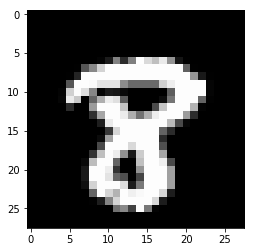

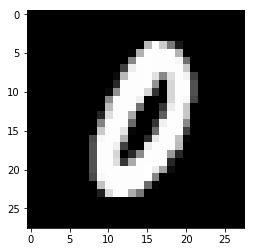

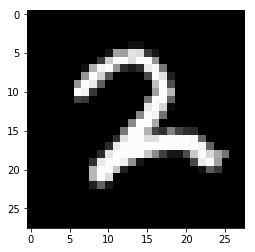

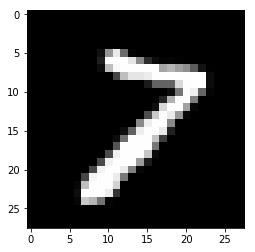

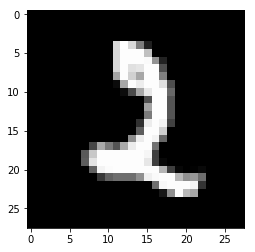

In [2]:
# load (downloaded if needed) the MNIST dataset
(X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()
# plot images
choice_array = np.random.choice(range(60000), size=5)
for i in range(len(choice_array)):
    plt.imshow(X_train[choice_array[i]], cmap=plt.get_cmap('gray'))
    plt.show()
# show the plot


In [3]:
# flatten
num_pixels = X_train_raw.shape[1] * X_train_raw.shape[2]
X_train = X_train.reshape(X_train_raw.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test_raw.shape[0], num_pixels).astype('float32')

In [4]:
# normalize
X_train = X_train / 255
X_test = X_test / 255

In [5]:
# 1-hot targets
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print(y_test)
print(y_test.shape)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(10000, 10)


In [25]:
def create_model(num_components=num_pixels, 
                 num_layers=1,
                 hidden_layer_size=num_pixels, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0000, 
                 activation='relu'):
    # create neural network with 1 hidden layer
    model = Sequential()

    # 1st layer is num_pixels size
    model.add(Dense(num_pixels, 
                    input_dim=num_pixels, 
                    kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l1(reg_penalty),                    
                    activation=activation))

    # dropout layer
    if dropout > 0:
        model.add(Dropout(dropout))
        
    # if hidden_layers > 1, add additional layers, input_dim is implicit from output of prev layer
    for _ in range(num_layers - 1):
        model.add(Dense(hidden_layer_size, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=regularizers.l1(reg_penalty),
                    activation=activation
                   ))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    # last layer is softmax
    model.add(Dense(num_classes, 
                    kernel_regularizer=regularizers.l1(reg_penalty),
                    kernel_initializer='normal', 
                    activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [26]:
# build and run the model
model = create_model(num_layers=2, hidden_layer_size=50)
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_6 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                39250     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                510       
Total params: 655,200.0
Trainable params: 655,200.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
7s - loss: 0.4848 - acc: 0.8554 - val_loss: 0.1615 - val_acc: 0.

In [40]:
hidden_layers_list= [1,2,3]
hidden_layer_size_list=[16,32,64]
dropout_list=[0, 0.333, 0.5]
reg_penalty_list = [0, 0.0001, 0.001, 0.01, 0.1, 1]
activation_list = ['relu', 'sigmoid']

epochs = 10
max_epochs = 10000
max_unimproved = 30
batch_size = 128

retlist = {}
for hidden_layers in hidden_layers_list:
    for hidden_layer_size in hidden_layer_size_list:
        for dropout in dropout_list:
            for reg_penalty in reg_penalty_list:
                for activation in activation_list:
                    create_model(num_components=num_pixels, 
                                 num_layers=hidden_layers,
                                 hidden_layer_size=hidden_layer_size, 
                                 dropout=dropout, 
                                 reg_penalty=reg_penalty, 
                                 activation=activation)

                    # train until no improvement in loss 
                    print("%s Starting" % (time.strftime("%H:%M:%S")))
                    best_loss = 0
                    best_epoch = 0
                    last_epoch = 0
                    for i in range(max_epochs / epochs):
                        fit = model.fit(X_train, 
                                        y_train, 
                                        validation_data=(X_test, y_test), 
                                        epochs=epochs, 
                                        batch_size=batch_size, 
                                        verbose=0)

                        #get best loss, break if not improved for max_unimproved epochs
                        train_loss_index = np.argmax(fit.history['val_acc'])
                        train_loss = fit.history['val_acc'][train_loss_index]
                        if train_loss > best_loss:
                            best_loss = train_loss
                            best_epoch = i * epochs + train_loss_index
                            print("%s Best accuracy now %f" % (time.strftime("%H:%M:%S"), best_loss))
                        else:
                            epochs_unimproved = (i + 1) * epochs - best_epoch
                            
                            if epochs_unimproved > max_unimproved:
                                break
                            else:
                                print("%s Best accuracy still %f after %d epochs" % (time.strftime("%H:%M:%S"), 
                                                                                 best_loss, epochs_unimproved))

                    print ("%s hidden_layers %d, hidden_layer_size %d, dropout %f, reg_penalty %f, activation %s" % 
                    (time.strftime("%H:%M:%S"), hidden_layers, hidden_layer_size, dropout, reg_penalty, activation)) 
                    print ("%s Final best accuracy %f" % (time.strftime("%H:%M:%S"), best_loss))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_67 (Dense)             (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290
Non-trainable params: 0.0
_________________________________________________________________
None
15:43:59 Starting
15:45:20 Best accuracy now 0.985900
15:46:41 Best accuracy still 0.985900 after 16 epochs
15:48:02 Best accuracy still 0.985900 after 26 epochs
15:49:23 Best accuracy now 0.986200
15:50:44 Best accuracy still 0.986200 after 11 epochs
15:52:04 Best accuracy still 0.986200 after 21 epochs
15:53:24 hidden_layers 1, hidden_layer_size 16, dropout 0.000000, reg_penalty 0.000000, activation relu
15:53:24 Final best accuracy 0.986200
_________________________________________________________________
Layer (ty

16:48:37 Best accuracy now 0.986100
16:49:58 Best accuracy still 0.986100 after 19 epochs
16:51:19 Best accuracy still 0.986100 after 29 epochs
16:52:40 hidden_layers 1, hidden_layer_size 16, dropout 0.000000, reg_penalty 0.100000, activation relu
16:52:40 Final best accuracy 0.986100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_85 (Dense)             (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290
Non-trainable params: 0.0
_________________________________________________________________
None
16:52:40 Starting
16:54:01 Best accuracy now 0.986100
16:55:21 Best accuracy still 0.986100 after 19 epochs
16:56:42 Best accuracy now 0.986700
16:58:02 Best accuracy still 0.986700 after 18 epochs
16:59:23 Best accuracy still 0.986700 a

17:51:41 Best accuracy now 0.987100
17:52:57 Best accuracy still 0.987100 after 13 epochs
17:54:13 Best accuracy still 0.987100 after 23 epochs
17:55:29 hidden_layers 1, hidden_layer_size 16, dropout 0.333000, reg_penalty 0.001000, activation relu
17:55:29 Final best accuracy 0.987100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 784)               615440    
_________________________________________________________________
dropout_13 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290.0
Non-trainable params: 0.0
_________________________________________________________________
None
17:55:29 Starting
17:56:45 Best accuracy now 0.985700
17:58:01 Best accuracy now 0.985800
17:59:17 Best

18:42:31 Best accuracy now 0.986300
18:43:47 Best accuracy still 0.986300 after 11 epochs
18:45:03 Best accuracy still 0.986300 after 21 epochs
18:46:20 hidden_layers 1, hidden_layer_size 16, dropout 0.500000, reg_penalty 0.000000, activation relu
18:46:20 Final best accuracy 0.986300
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 784)               615440    
_________________________________________________________________
dropout_21 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290.0
Non-trainable params: 0.0
_________________________________________________________________
None
18:46:20 Starting
18:47:36 Best accuracy now 0.986500
18:48:52 Best accuracy still 0.986500 after 15 ep

19:43:44 Best accuracy still 0.987500 after 23 epochs
19:45:01 hidden_layers 1, hidden_layer_size 16, dropout 0.500000, reg_penalty 0.010000, activation sigmoid
19:45:01 Final best accuracy 0.987500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 784)               615440    
_________________________________________________________________
dropout_28 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290.0
Non-trainable params: 0.0
_________________________________________________________________
None
19:45:01 Starting
19:46:18 Best accuracy now 0.986000
19:47:35 Best accuracy now 0.986500
19:48:51 Best accuracy still 0.986500 after 15 epochs
19:50:07 Best accuracy still 0.986500 after 25

20:50:10 Best accuracy now 0.986300
20:51:27 Best accuracy still 0.986300 after 16 epochs
20:52:44 Best accuracy still 0.986300 after 26 epochs
20:54:01 Best accuracy now 0.986500
20:55:17 Best accuracy still 0.986500 after 20 epochs
20:56:33 Best accuracy still 0.986500 after 30 epochs
20:57:49 hidden_layers 1, hidden_layer_size 32, dropout 0.000000, reg_penalty 0.000100, activation sigmoid
20:57:49 Final best accuracy 0.986500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_147 (Dense)            (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290
Non-trainable params: 0.0
_________________________________________________________________
None
20:57:49 Starting
20:59:06 Best accuracy now 0.985700
21:00:22 Best accuracy now 0.985900


21:58:15 Best accuracy now 0.986500
21:59:33 Best accuracy now 0.986700
22:00:50 Best accuracy now 0.987000
22:02:07 Best accuracy still 0.987000 after 17 epochs
22:03:25 Best accuracy still 0.987000 after 27 epochs
22:04:42 hidden_layers 1, hidden_layer_size 32, dropout 0.000000, reg_penalty 1.000000, activation sigmoid
22:04:42 Final best accuracy 0.987000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 784)               615440    
_________________________________________________________________
dropout_32 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 10)                7850      
Total params: 623,290.0
Trainable params: 623,290.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:04:43 Starting
22:06:01 B

KeyboardInterrupt: 

In [ ]:
#conv net
# reshape raw data to be [samples][pixels][width][height]
X_train = X_train_raw.reshape(X_train_raw.shape[0], 1, 28, 28).astype('float32')
X_test = X_test_raw.reshape(X_test_raw.shape[0], 1, 28, 28).astype('float32')
# normalize
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
def create_convnet(conv1units=30,
                 conv1size=5,
                 pool1size=2
                 conv2units=15,
                 conv2size=3,
                 pool2size=2,
                 dropout=0.2,
                 dense1size=128,
                 dense2size=50
                ):
    # create model
    model = Sequential()
    model.add(Conv2D(conv1units, (conv1size, conv1size), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(pool1size, pool1size)))
    model.add(Conv2D(conv2units, (conv2size, conv2size), activation='relu'))
    model.add(MaxPooling2D(pool_size=(pool2size, pool2size)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(dense1size, activation='relu'))
    model.add(Dense(dense2size, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
